# Аналитика в Яндекс.Афише

### У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши
* выгрузка всех заказов за этот период
* статистика рекламных расходов

### Что нам необходимо изучить:
* как люди пользуются продуктом
* когда они начинают покупать
* сколько денег приносит каждый клиент
* когда клиент окупается

### Оглавление:
* [Подготовка данных к анализу](#step1)
* [Построение отчётов и подсчет метрик](#step2)
    * [Продукт](#step2_1)
        * [Сколько людей пользуются в день, неделю, месяц?](#step2_1_1)
        * [Сколько сессий в день?](#step2_1_2)
        * [Сколько длится одна сессия?](#step2_1_3)
        * [Как часто люди возвращаются?](#step2_1_4)
    * [Продажи](#step2_2)
        * [Когда люди начинают покупать?](#step2_2_1)
        * [Сколько раз покупают за период?](#step2_2_2)
        * [Какой средний чек?](#step2_2_3)
        * [Сколько денег приносят? (LTV)](#step2_2_4)
    * [Маркетинг](#step2_3)
        * [Сколько денег потратили? Всего / на каждый источник / по времени](#step2_3_1)
        * [Сколько стоило привлечение одного покупателя из каждого источника?](#step2_3_2)
        * [На сколько окупились расходы? (ROI)](#step2_3_3)
        * [Когда киенты начинают окупаться. Расчет ROMI.](#step2_3_4)
* [Итоговые выводы](#step3)

##### Импортируем библиотеки, выгрузим и изучим таблицы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats as st

 ### Шаг 1. Загрузим данные и подготовим их к анализу<a id="step1"></a>

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.info()
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Приведем к единому регистру названия столбцов и заменим пробелы, а так же приведем столбцы с датами к нужному формату.

In [4]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_')
visits['end_ts'] = pd.to_datetime(visits['end_ts'],  format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'],  format = '%Y-%m-%d %H:%M:%S')
visits.info()
visits.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


То же самое сделаем с остальными таблицами.

In [6]:
orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'],  format = '%Y-%m-%d %H:%M:%S')
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
costs.info()
costs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [8]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


## Шаг 2. Построим отчёты и посчитаем метрики<a class="anchor" id="step2"></a>

### 2.1 Продукт<a class="anchor" id="step2_1"></a>
##### Сколько людей пользуются в день, неделю, месяц?<a class="anchor" id="step2_1_1"></a>

In [9]:
visits['date'] = visits['start_ts'].dt.date
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['week']  = visits['start_ts'].astype('datetime64[W]')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-14
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-15
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-29
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018-05-17
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,2017-12-21


In [10]:
# Сгруппируем данные по уникальным пользователям и найдем среднее
dau = visits.groupby('date').agg({'uid': 'nunique'})
wau = visits.groupby('week').agg({'uid': 'nunique'})
mau = visits.groupby('month').agg({'uid': 'nunique'})

In [11]:
print("Среднее количество уникальных пользователей в день DAU: {0:.2f} человек".format(dau.mean()[0]))
print("Среднее количество уникальных пользователей в неделю WAU: {0:.2f} человек".format(wau.mean()[0]))
print("Среднее количество уникальных пользователей в месяц MAU: {0:.2f} человек".format(mau.mean()[0]))

Среднее количество уникальных пользователей в день DAU: 907.99 человек
Среднее количество уникальных пользователей в неделю WAU: 5724.42 человек
Среднее количество уникальных пользователей в месяц MAU: 23228.42 человек


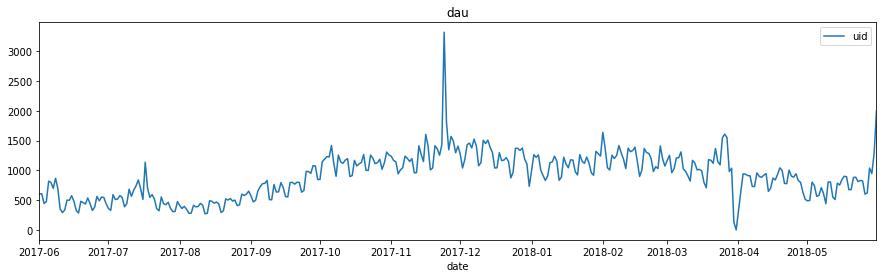

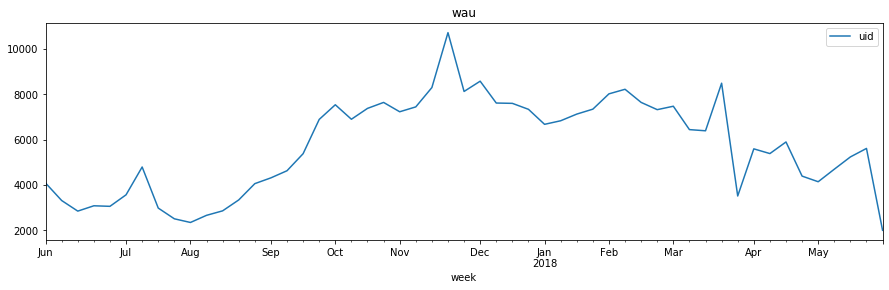

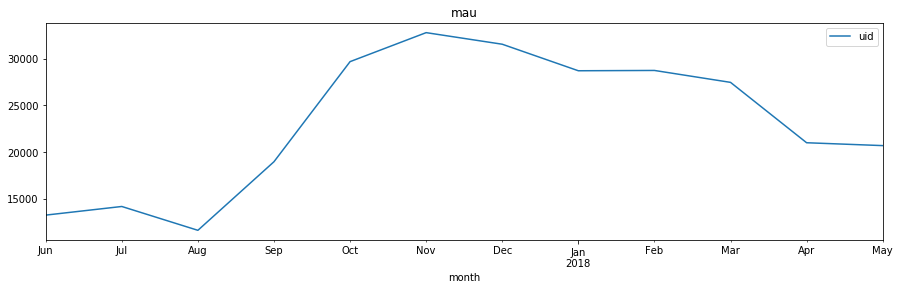

In [12]:
# Из любопытства визуализируем данные
dau.plot(title = 'dau', figsize = (15,4))
wau.plot(title = 'wau', figsize = (15,4))
mau.plot(title = 'mau', figsize = (15,4))
plt.show()

##### Сколько сессий в день?<a class="anchor" id="step2_1_2"></a>

In [13]:
session_count = visits.groupby('date').agg({'uid': 'count'}).mean()
print("Среднее количество сессий в день: {0:.2f} ".format(session_count[0]))

Среднее количество сессий в день: 987.36 


##### Сколько длится одна сессия?<a class="anchor" id="step2_1_3"></a>

In [14]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

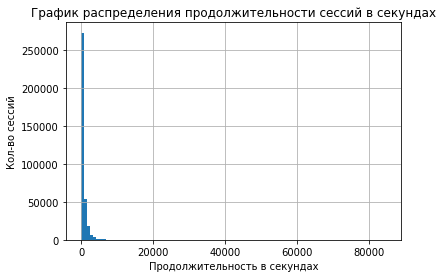

In [15]:
# Взглянем на распределение
ax = visits['session_duration_sec'].hist(bins = 100)
plt.title('График распределения продолжительности сессий в секундах')
ax.set_xlabel('Продолжительность в секундах')
ax.set_ylabel('Кол-во сессий')
plt.show()

In [16]:
# Посмотрим на выбивающиеся значения
visits.query('session_duration_sec > 30000')

,device,end_ts,source_id,start_ts,uid,date,month,week,session_duration_sec
1197,desktop,2017-07-21 20:06:00,1,2017-07-21 11:04:00,2909927403543287328,2017-07-21,2017-07-01,2017-07-20,32520
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-25,2018-03-01,2018-03-22,84480
125667,desktop,2018-03-10 22:14:00,2,2018-03-10 13:52:00,5599048030526707311,2018-03-10,2018-03-01,2018-03-08,30120
177381,desktop,2017-08-01 20:58:00,1,2017-08-01 11:02:00,2909927403543287328,2017-08-01,2017-08-01,2017-07-27,35760
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-25,2018-03-01,2018-03-22,83640
221945,desktop,2017-07-29 19:46:00,2,2017-07-29 11:02:00,2909927403543287328,2017-07-29,2017-07-01,2017-07-27,31440
229891,desktop,2017-12-18 22:43:00,3,2017-12-18 10:52:00,15566184277200431914,2017-12-18,2017-12-01,2017-12-14,42660
248062,desktop,2017-07-27 20:21:00,1,2017-07-27 11:13:00,2909927403543287328,2017-07-27,2017-07-01,2017-07-27,32880
337996,touch,2017-11-10 00:43:00,2,2017-11-09 16:09:00,15273714129857295034,2017-11-09,2017-11-01,2017-11-09,30840


Можно увидеть, что два самых больших значения явно являются ошибкой в данных, так как время конца сессии меньше чем время начала сессии. И кстати они произошли в один и тот же день: 25 марта 2017 года. Возможно ошибка произошла из-за того, что в этот происходит перевод часов на летнее время, хотя в России эту практику отменили еще в 2011 году.

In [17]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [18]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Итак, можно сделать вывод:
* Среднее время сессии составляет **643 секунды**, почти 11 минут.
* Медианное время сессии **300 секунд**, то есть ровно 5 минут.
* Мода - самое встречающееся значение, состявляет **60 секунд**, 1 минуту.

##### Для оценки распределния я бы выбрал медианное значение равное 5 минутам, так как оно невосприимчиво к выбросам.

##### Как часто люди возвращаются?<a class="anchor" id="step2_1_4"></a>

In [19]:
# найдем дату, когда пользователь впервые зашел на сайт и добавим ее в таблицу visits
first_visit = visits.groupby(['uid'])['start_ts'].min()
first_visit.name = 'first_visit'

In [20]:
first_visit.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_visit, dtype: datetime64[ns]

In [21]:
visits = visits.join(first_visit,on='uid')

In [22]:
# выделим месяц из столбцов first_visit и start_ts
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')

In [23]:
# рассчитаем lifetime пользователей в рамках когорты
visits['cohort_lifetime'] = visits['start_ts_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [24]:
visits.sample(8)

,device,end_ts,source_id,start_ts,uid,date,month,week,session_duration_sec,first_visit,first_visit_month,start_ts_month,cohort_lifetime
281738,desktop,2017-07-18 07:57:00,3,2017-07-18 07:47:00,18318159197984153351,2017-07-18,2017-07-01,2017-07-13,600,2017-07-18 07:47:00,2017-07-01,2017-07-01,0
105618,desktop,2018-05-21 17:47:00,5,2018-05-21 17:42:00,1236458250580019193,2018-05-21,2018-05-01,2018-05-17,300,2018-05-21 17:42:00,2018-05-01,2018-05-01,0
69086,desktop,2017-10-26 22:54:00,5,2017-10-26 22:46:00,959049421240361673,2017-10-26,2017-10-01,2017-10-26,480,2017-10-26 22:46:00,2017-10-01,2017-10-01,0
303793,desktop,2017-07-02 00:11:00,2,2017-07-02 00:02:00,13322950956178616539,2017-07-02,2017-07-01,2017-06-29,540,2017-07-02 00:02:00,2017-07-01,2017-07-01,0
12832,desktop,2017-12-14 18:17:00,5,2017-12-14 18:15:00,3898315022211231262,2017-12-14,2017-12-01,2017-12-14,120,2017-12-14 18:15:00,2017-12-01,2017-12-01,0
258680,touch,2018-01-21 20:56:00,1,2018-01-21 20:42:00,12803131467068729885,2018-01-21,2018-01-01,2018-01-18,840,2018-01-06 20:34:00,2018-01-01,2018-01-01,0
82397,desktop,2017-08-31 21:56:00,9,2017-08-31 21:55:00,15250499413999327662,2017-08-31,2017-08-01,2017-08-31,60,2017-08-05 01:03:00,2017-08-01,2017-08-01,0
39600,touch,2017-07-24 10:15:00,2,2017-07-24 10:15:00,2780731190773559022,2017-07-24,2017-07-01,2017-07-20,0,2017-07-24 10:15:00,2017-07-01,2017-07-01,0


In [25]:
# сгруппируем данные по когорте и lifetime и посчитаем количество активных пользоватлей на каждый месяц жизни когорты
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.tail(10)

,first_visit_month,cohort_lifetime,uid
68,2018-02-01,0,22197
69,2018-02-01,1,1267
70,2018-02-01,2,565
71,2018-02-01,3,446
72,2018-03-01,0,20589
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760
77,2018-05-01,0,15273


In [26]:
# найдем исходное количетсво уникальных пользователей для каждой когорты взяв нулевой lifetime
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
initial_users_count

,first_visit_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [27]:
# Объединим таблицы cohorts и initial_users_count 
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')
cohorts.head()

,first_visit_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [28]:
# рассчитаем retention
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

In [29]:
# построим сводную таблицу, по которой далее создадим тепловую карту
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

In [30]:
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# добавим среднее значение retention rate по столбцу
retention_pivot_mean = retention_pivot.mean().to_frame().T
retention_pivot = retention_pivot_mean.append(retention_pivot)
retention_pivot = retention_pivot.rename({0:'mean'})

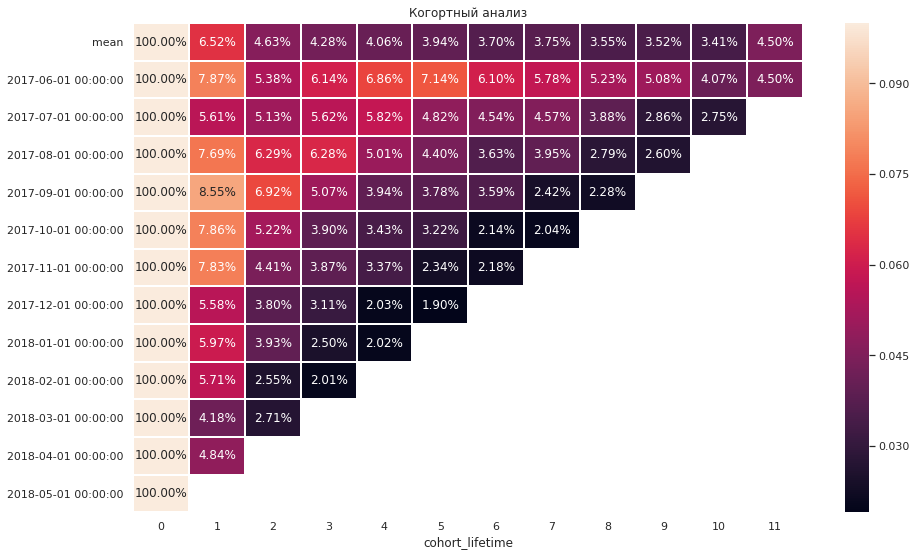

In [32]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Когортный анализ')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, vmax=0.1, linecolor='white')
#ax.set_yticklabels(retention_pivot.index.date)
plt.show()

In [33]:
retention_pivot.mean(axis = 0)*100

cohort_lifetime
0     100.000000
1       6.516660
2       4.633262
3       4.275990
4       4.059457
5       3.944383
6       3.695659
7       3.750912
8       3.546465
9       3.515906
10      3.406250
11      4.495060
dtype: float64

##### Выводы: 
В целом люди пользуются сервисом всего один раз, потом примерно 2-8% людей которые возвращаются, и с каждым последующим месяцем кол-во людей не сильно сокращается, если сравнивать разницу 0 и 1 месяца. Возможно, это связано с тем, что большинство людей в целом редко ходят на какие-либо мероприятия и интересуются ими, не считая редких любителей.

### 2.2 Продажи<a class="anchor" id="step2_2"></a>
##### Когда люди начинают покупать?<a class="anchor" id="step2_2_1"></a>

In [34]:
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.rename(columns={'start_ts':'first_visit'})
first_visit.head()

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [35]:
first_order = orders.groupby(['uid'])['buy_ts'].min().reset_index()
first_order.rename(columns={'buy_ts':'first_buy'})

,uid,first_buy
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [36]:
buying_time = first_visit.merge(first_order, on='uid', how='inner')

In [37]:
buying_time['buying_time'] = buying_time['buy_ts'] - buying_time['start_ts']

In [38]:
buying_time

,uid,start_ts,buy_ts,buying_time
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00
...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00,95 days 19:33:00
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,0 days 00:07:00
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,231 days 11:03:00
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00,103 days 09:33:00


In [39]:
buying_time['buying_time'] = buying_time['buying_time'] / np.timedelta64(1,'D')
buying_time['buying_time'].astype('int')

0        106
1          0
2          0
3          0
4          0
        ... 
36518     95
36519      0
36520    231
36521    103
36522      0
Name: buying_time, Length: 36523, dtype: int64

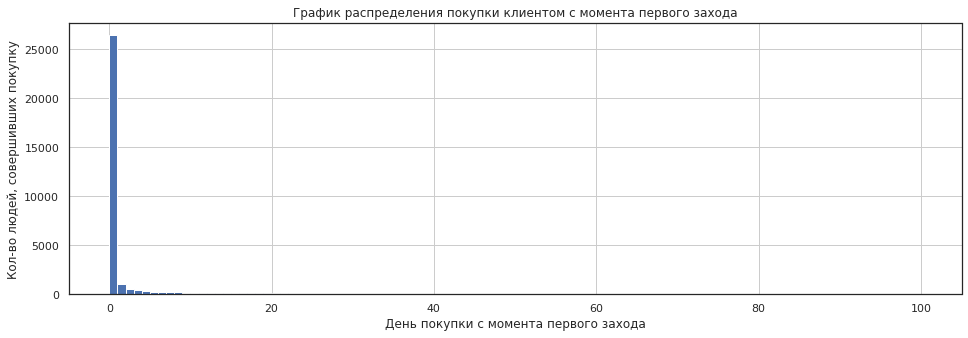

In [40]:
ax = buying_time['buying_time'].hist(bins=100,figsize = (16,5), range=(0,100))
plt.title('График распределения покупки клиентом с момента первого захода')
ax.set_xlabel('День покупки с момента первого захода')
ax.set_ylabel('Кол-во людей, совершивших покупку')
plt.show()

In [41]:
buying_time['buying_time'].describe()

count    36523.000000
mean        16.902900
std         47.072760
min          0.000000
25%          0.002778
50%          0.011111
75%          2.011806
max        363.294444
Name: buying_time, dtype: float64

##### Вывод:
Практически все пользователи совершают свою первую покупку в первый же день посещения Яндекс.Афиши. Очень малая часть - на протяжении недели от первого визита. Среднее значение в 17 дней образовалось исключительно из-за выбросов.

##### Сколько раз покупают за период?<a class="anchor" id="step2_2_2"></a>

In [42]:
orders_cnt = orders.copy()

Добавим в таблицу день, неделю и месяц, сгруппируем, посчитав количество и создадим датафрем применив медот `describe()` к каждому получившемуся столбцу

In [43]:
orders_cnt['purchase_date'] = orders_cnt['buy_ts'].dt.date
orders_cnt['purchase_week'] = orders_cnt['buy_ts'].dt.week
orders_cnt['purchase_month'] = orders_cnt['buy_ts'].dt.month

In [44]:
orders_cnt.head()

,buy_ts,revenue,uid,purchase_date,purchase_week,purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6


In [45]:
purchases_per_day = orders_cnt.groupby('purchase_date')['uid'].count()
purchases_per_week = orders_cnt.groupby('purchase_week')['uid'].count()
purchases_per_month = orders_cnt.groupby('purchase_month')['uid'].count()

In [46]:
orders_cnt_data = pd.DataFrame({"purchases_per_day":pd.Series(purchases_per_day.describe()),
                   "purchases_per_week":pd.Series(purchases_per_week.describe()),
                   "purchases_per_month":pd.Series(purchases_per_month.describe())}).round()


In [47]:
orders_cnt_data

,purchases_per_day,purchases_per_week,purchases_per_month
count,364.0,52.0,12.0
mean,139.0,970.0,4201.0
std,77.0,398.0,1512.0
min,1.0,314.0,1807.0
25%,83.0,658.0,3046.0
50%,136.0,998.0,4534.0
75%,177.0,1270.0,5409.0
max,814.0,1894.0,6218.0


##### Вывод:
* В день с среднем соврешают 139 покупок, минимально была зафиксирована одна покупка в день, максимально было совершено 814 покупок.
* В неделю 970 покупок, минимум было совершено 398 покупок, максимум - 1894.
* Среднее количество покупок в месяц равняется 4201. В самый "бедный" на покупки месяц было совершено всего 1807 покупок.

##### Какой средний чек?<a class="anchor" id="step2_2_3"></a>

In [48]:
orders_cnt

,buy_ts,revenue,uid,purchase_date,purchase_week,purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,22,5
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,22,5
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,22,5
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,22,5


In [49]:
orders_cnt['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

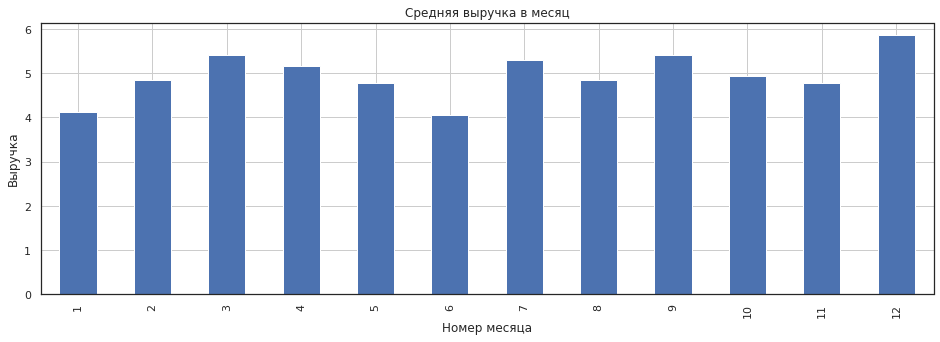

In [50]:
ax = orders_cnt.groupby('purchase_month')['revenue'].mean().plot(kind='bar', figsize=(16, 5), grid = True)
plt.title('Средняя выручка в месяц')
ax.set_xlabel('Номер месяца')
ax.set_ylabel('Выручка')
plt.show()

**Средний чек** равен 5. Если сделать распределение по месяца, то в среднем он колеблется от 4 до 6.

Отдельно посчитаем **средний чек** ***на покупателя***.

In [51]:
print('Средний чек на покупаетля равен:', orders_cnt['revenue'].sum() / orders_cnt['uid'].nunique())

Средний чек на покупаетля равен: 6.9013279303452615


##### Сколько денег приносят? (LTV)<a class="anchor" id="step2_2_4"></a>

In [52]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [53]:
# создадим когорты по месяцам
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [54]:
first_orders = orders.groupby('uid').agg({'month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_buy_month']
first_orders.head()

,uid,first_buy_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [55]:
# посчитаем кол-во новых покупателей за каждый месяц
cohort_sizes = first_orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
cohort_sizes

,first_buy_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [56]:
# добавим каждому покупателю месяц первой покупки
orders_new = pd.merge(orders,first_orders, on='uid')
orders_new.head()

,buy_ts,revenue,uid,month,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [57]:
# cгруппируем по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders_new.groupby(['first_buy_month','month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_buy_month,month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [58]:
ltv = pd.merge(cohort_sizes, cohorts, on='first_buy_month')
ltv.head()

,first_buy_month,n_buyers,month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


LTV Считается из валовой прибыли. Валовая прибыль это выручка умноженная на маржинальность, а так как маржинальность не задана, примем ее значение за единицу, то есть LTV считаем из выручки. Создадим столбец с возрастом каждой когорты.

In [59]:
# добавим возраст когорты
ltv['age'] = (ltv['month'] - ltv['first_buy_month']) / np.timedelta64(1, 'M')
ltv['age'] = ltv['age'].round().astype('int')
ltv.head()

,first_buy_month,n_buyers,month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


In [60]:
# зададаим MARGIN_RATE и посчитаем LTV
MARGIN_RATE = 1
ltv['gp'] = ltv['revenue'] * MARGIN_RATE
ltv['ltv'] = ltv['gp'] / ltv['n_buyers']
ltv.head()

,first_buy_month,n_buyers,month,revenue,age,gp,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,9557.49,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,981.82,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,885.34,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,1931.30,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,2068.58,1.022531


In [61]:
ltv_sum = ltv.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1).round(2)
    
ltv_sum.fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


In [62]:
# просуммируем прибыль
#ltv_sum = ltv_data.cumsum(axis=1)
#ltv_sum.fillna('')

In [63]:
ltv_sum_mean = ltv_sum.mean().to_frame().T
ltv_sum = ltv_sum_mean.append(ltv_sum)
ltv_sum = ltv_sum.rename({0:'mean'})

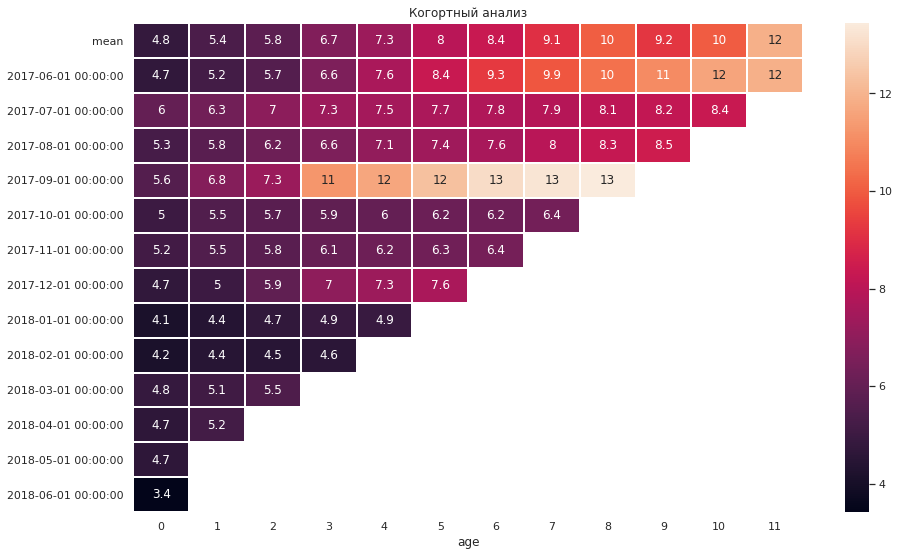

In [64]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Когортный анализ')
ax = sns.heatmap(ltv_sum, annot=True, linewidths=1, linecolor='white')
#ax.set_yticklabels(retention_pivot.index.date)
plt.show()

In [65]:
ltv_sum.mean(axis = 0)

age
0      4.801538
1      5.396364
2      5.821000
3      6.691111
4      7.297500
5      7.970000
6      8.388333
7      9.082000
8     10.062500
9      9.250000
10    10.005000
11    11.880000
dtype: float64

In [66]:
# построим отдельную талицу для удобства
#cohort_ltv = (ltv_sum.apply(lambda row: row.max(), axis=1)).reset_index()
#cohort_ltv.columns = ['cohort','sum_ltv']
#cohort_ltv

<s>Самыми прибыльными когортами являются те, в которых пользователи пришли в июне и в сентябре</s>

Из данной таблицы можно сделать вывод, что в первый месяц своей жизни в среднем когорты приносят 4.8 у.е. выручки. Дальше с возрастом когорт это показатель постепенно растет по ~0.8 у.е. в месяц.

### 2.3 Маркетинг<a class="anchor" id="step2_3"></a>
##### Сколько денег потратили? Всего / на каждый источник / по времени<a class="anchor" id="step2_3_1"></a>

In [67]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [68]:
print('Всего потратили:',costs['costs'].sum())

Всего потратили: 329131.62


In [69]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


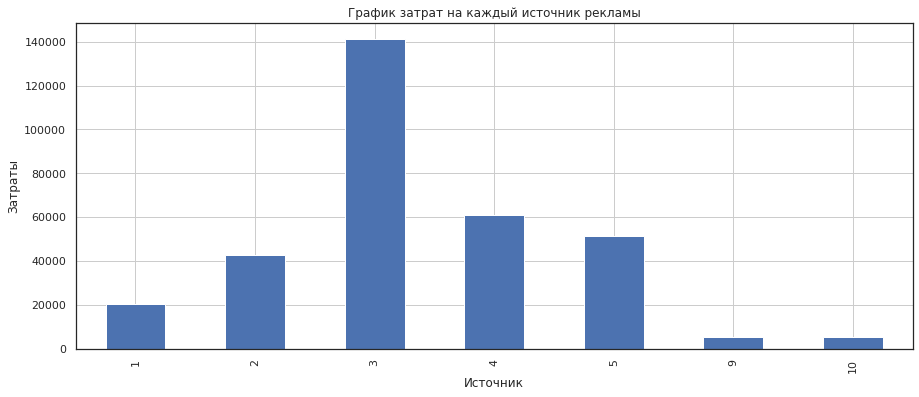

In [70]:
# Для наглядности построим график типа barplot
costs_by_source.set_index('source_id', inplace=True)
ax = costs_by_source['costs'].plot(kind='bar', figsize=(15,6), grid = True)
plt.title('График затрат на каждый источник рекламы')
ax.set_xlabel('Источник')
ax.set_ylabel('Затраты')
plt.show()

In [71]:
# для подсчета затрат по времени выделим месяца, и по ним построим график
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

In [72]:
costs_by_month = costs.groupby('costs_month')['costs'].sum().reset_index()
costs_by_month

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [73]:
month_name = ['Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']

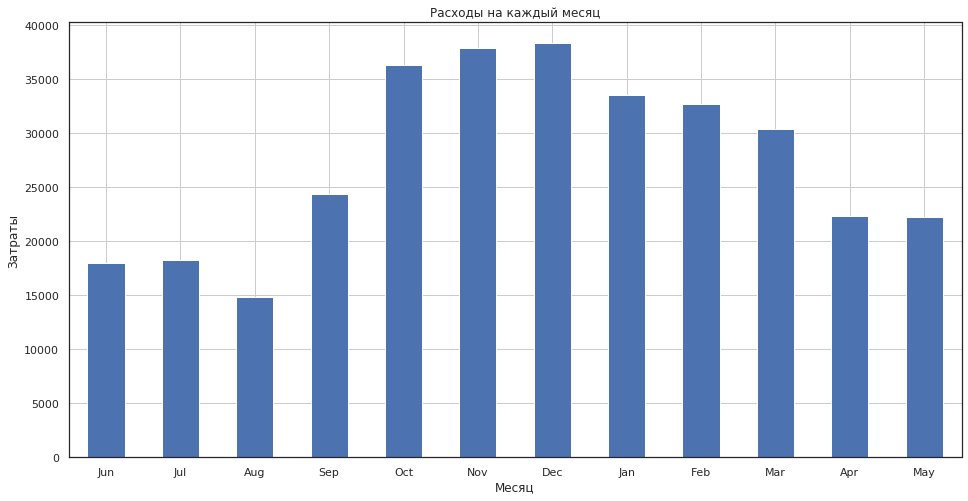

In [74]:
ax = costs_by_month = costs.groupby('costs_month')['costs'].sum().plot(kind='bar', figsize=(16, 8), grid = True)
plt.title('Расходы на каждый месяц')
ax.set_xticklabels(month_name, rotation=0)
ax.set_xlabel('Месяц')
ax.set_ylabel('Затраты')
plt.show()

##### Выводы:
* Больше всего затрачено было на 3 и 4 источники.
* Так же по месяцам больше всего денег потратили в октябре, ноябре и декабре.

#### Сколько стоило привлечение одного покупателя из каждого источника?<a class="anchor" id="step2_3_2"></a>

In [75]:
costs

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [76]:
# сгруппируем по источникам и посчитаем сумму затрат на каждый источник
costs_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
costs_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [77]:
# отфильтруем таблицуЮ в которой будут только первые посещения пользователей
visits_source = visits.query('start_ts == first_visit')

In [78]:
orders.head(5)

,buy_ts,revenue,uid,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [79]:
# объединим две таблицы способом inner, что бы остались только те пользователи, которые совершали покупки
source_data = orders.merge(visits_source, on='uid', how='inner')
source_data.head()

,buy_ts,revenue,uid,month_x,device,end_ts,source_id,start_ts,date,month_y,week,session_duration_sec,first_visit,first_visit_month,start_ts_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017-06-01,2017-06-01,2017-06-01,120,2017-06-01 00:09:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01,660,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,540,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01,1140,2017-06-01 00:14:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017-06-01,2017-06-01,2017-06-01,1680,2017-06-01 07:31:00,2017-06-01,2017-06-01,0


In [80]:
# сгруппируем , что бы найти уникальных пользователей для каждого источника
buyers_source = source_data.groupby('source_id').agg({'uid':'nunique'}).reset_index()
buyers_source.columns = ['source_id','n_buyers']
buyers_source

,source_id,n_buyers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [81]:
# соединим две таблицы вместе
cac = buyers_source.merge(costs_source)
cac

,source_id,n_buyers,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,9,1088,5517.49
6,10,1329,5822.49


In [82]:
cac['cac'] = cac['costs'] / cac['n_buyers']
cac

,source_id,n_buyers,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


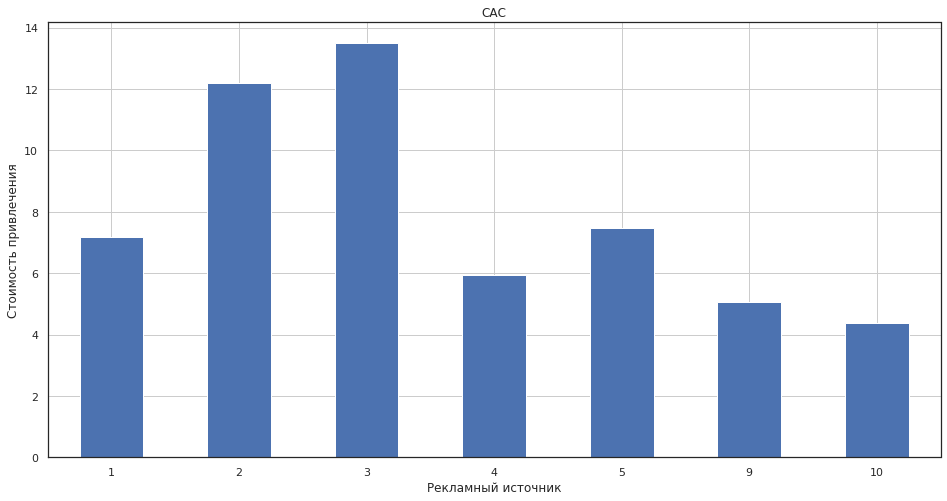

In [83]:
# визуализируем таблицу
ax = cac['cac'].plot(kind='bar', figsize=(16, 8), grid = True)
plt.title('CAC')
ax.set_xticklabels(cac['source_id'], rotation=0)
ax.set_xlabel('Рекламный источник')
ax.set_ylabel('Стоимость привлечения')
plt.show()

Больше всего средств для привлечения клиентов вкладывается в источники **3** и **2**, следующие по убыванию **5** и **1**. 

#### На сколько окупились расходы? (ROI)<a class="anchor" id="step2_3_3"></a>

In [84]:
costs_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [85]:
# сгруппируем данный из уже имеющейся таблицы , тольуо на этот раз просуммируем доход от источника
revenue_data = source_data.groupby('source_id').agg({'revenue':'sum'}).reset_index()
revenue_data

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


In [86]:
roi = revenue_data.merge(costs_source)
roi

,source_id,revenue,costs
0,1,31090.55,20833.27
1,2,46923.61,42806.04
2,3,54511.24,141321.63
3,4,56696.83,61073.60
4,5,52624.02,51757.10
5,9,5759.40,5517.49
6,10,4450.33,5822.49


In [87]:
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']
roi

,source_id,revenue,costs,roi
0,1,31090.55,20833.27,0.492351
1,2,46923.61,42806.04,0.096191
2,3,54511.24,141321.63,-0.614275
3,4,56696.83,61073.60,-0.071664
4,5,52624.02,51757.10,0.016750
5,9,5759.40,5517.49,0.043844
6,10,4450.33,5822.49,-0.235665


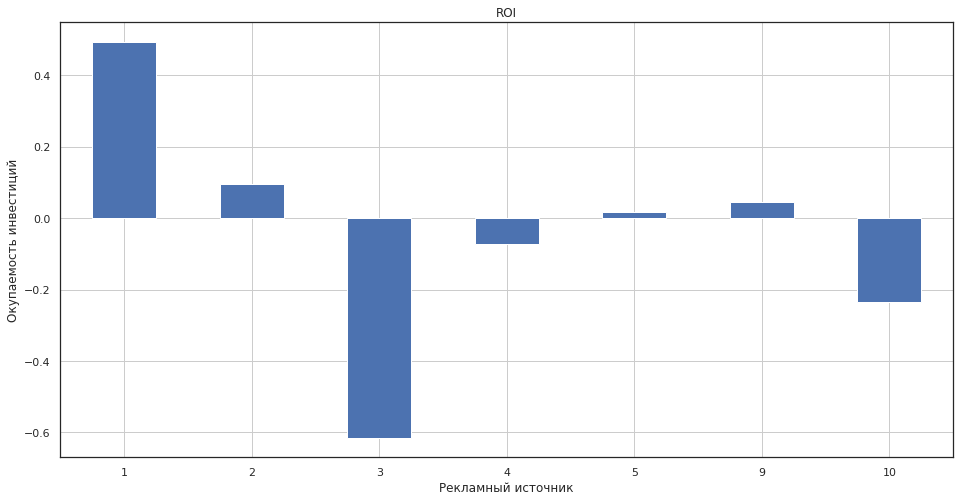

In [88]:
ax = roi['roi'].plot(kind='bar', figsize=(16, 8), grid = True)
plt.title('ROI')
ax.set_xticklabels(roi['source_id'], rotation=0)
ax.set_xlabel('Рекламный источник')
ax.set_ylabel('Окупаемость инвестиций')
plt.show()

Мы видим, что окупились только источники **1, 2, 5 и 6**, причем у всех кроме **1** окупаемость довольно слабая. У остальных же источников этот показательи вовсе отрицательный, то есть они еще не окупились.

#### Посчитаем ROMI и узнаем срок окупаемости каждого источника релкамы. <a class="anchor" id="step2_3_4"></a>

In [89]:
# в это табличке я уже отфильтровал пользователей, визит которых был первым
visits_source.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,session_duration_sec,first_visit,first_visit_month,start_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-14,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-15,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-29,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,2017-12-21,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-09-01,2017-08-31,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0


In [90]:
orders.head()

,buy_ts,revenue,uid,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [91]:
df = visits_source.merge(orders, on='uid')

In [92]:
n_users = df.groupby(['first_visit_month','source_id']).agg({'uid': 'nunique'}).reset_index()
n_users.head()

,first_visit_month,source_id,uid
0,2017-06-01,1,240
1,2017-06-01,2,374
2,2017-06-01,3,886
3,2017-06-01,4,647
4,2017-06-01,5,509


In [93]:
rev_sum = df.groupby(['first_visit_month','source_id','month_y',]).agg({'revenue': 'sum'}).reset_index()
rev_sum

,first_visit_month,source_id,month_y,revenue
0,2017-06-01,1,2017-06-01,1378.70
1,2017-06-01,1,2017-07-01,662.73
2,2017-06-01,1,2017-08-01,683.12
3,2017-06-01,1,2017-09-01,1613.45
4,2017-06-01,1,2017-10-01,1055.58
...,...,...,...,...
535,2018-05-01,4,2018-05-01,2516.80
536,2018-05-01,4,2018-06-01,3.42
537,2018-05-01,5,2018-05-01,1697.01
538,2018-05-01,9,2018-05-01,83.82


In [94]:
df_final = rev_sum.merge(n_users, on=['source_id','first_visit_month'])
df_final.columns = ['first_order_month','source_id','month','revenue','n_buyers']
df_final.head()

,first_order_month,source_id,month,revenue,n_buyers
0,2017-06-01,1,2017-06-01,1378.70,240
1,2017-06-01,1,2017-07-01,662.73,240
2,2017-06-01,1,2017-08-01,683.12,240
3,2017-06-01,1,2017-09-01,1613.45,240
4,2017-06-01,1,2017-10-01,1055.58,240


In [95]:
df_final['age'] = ((df_final['month'] - df_final['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')
df_final.head()

,first_order_month,source_id,month,revenue,n_buyers,age
0,2017-06-01,1,2017-06-01,1378.70,240,0
1,2017-06-01,1,2017-07-01,662.73,240,1
2,2017-06-01,1,2017-08-01,683.12,240,2
3,2017-06-01,1,2017-09-01,1613.45,240,3
4,2017-06-01,1,2017-10-01,1055.58,240,4


In [96]:
df_final['ltv'] = df_final['revenue'] / df_final['n_buyers']
df_final.head()

,first_order_month,source_id,month,revenue,n_buyers,age,ltv
0,2017-06-01,1,2017-06-01,1378.70,240,0,5.744583
1,2017-06-01,1,2017-07-01,662.73,240,1,2.761375
2,2017-06-01,1,2017-08-01,683.12,240,2,2.846333
3,2017-06-01,1,2017-09-01,1613.45,240,3,6.722708
4,2017-06-01,1,2017-10-01,1055.58,240,4,4.398250


In [97]:
costs_sum = costs.groupby(['source_id','costs_month']).agg({'costs':'sum'}).reset_index()
costs_sum.columns = ['source_id','month','costs']

In [98]:
df_final = df_final.merge(costs_sum, on=['source_id','month'])
df_final.head()

,first_order_month,source_id,month,revenue,n_buyers,age,ltv,costs
0,2017-06-01,1,2017-06-01,1378.70,240,0,5.744583,1125.61
1,2017-06-01,1,2017-07-01,662.73,240,1,2.761375,1072.88
2,2017-07-01,1,2017-07-01,918.95,184,0,4.994293,1072.88
3,2017-06-01,1,2017-08-01,683.12,240,2,2.846333,951.81
4,2017-07-01,1,2017-08-01,131.13,184,1,0.712663,951.81


In [99]:
df_final['cac'] = df_final['costs'] / df_final['n_buyers']

In [100]:
df_final['romi'] = df_final['ltv'] / df_final['cac']
df_final

,first_order_month,source_id,month,revenue,n_buyers,age,ltv,costs,cac,romi
0,2017-06-01,1,2017-06-01,1378.70,240,0,5.744583,1125.61,4.690042,1.224847
1,2017-06-01,1,2017-07-01,662.73,240,1,2.761375,1072.88,4.470333,0.617711
2,2017-07-01,1,2017-07-01,918.95,184,0,4.994293,1072.88,5.830870,0.856526
3,2017-06-01,1,2017-08-01,683.12,240,2,2.846333,951.81,3.965875,0.717706
4,2017-07-01,1,2017-08-01,131.13,184,1,0.712663,951.81,5.172880,0.137769
...,...,...,...,...,...,...,...,...,...,...
533,2017-11-01,10,2018-04-01,2.69,138,5,0.019493,388.25,2.813406,0.006929
534,2018-01-01,10,2018-04-01,4.66,103,3,0.045243,388.25,3.769417,0.012003
535,2018-02-01,10,2018-04-01,0.49,113,2,0.004336,388.25,3.435841,0.001262
536,2018-03-01,10,2018-04-01,22.42,166,1,0.135060,388.25,2.338855,0.057746


In [101]:
output_cohort_v2 = df_final.pivot_table(
        index=['month'], 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)

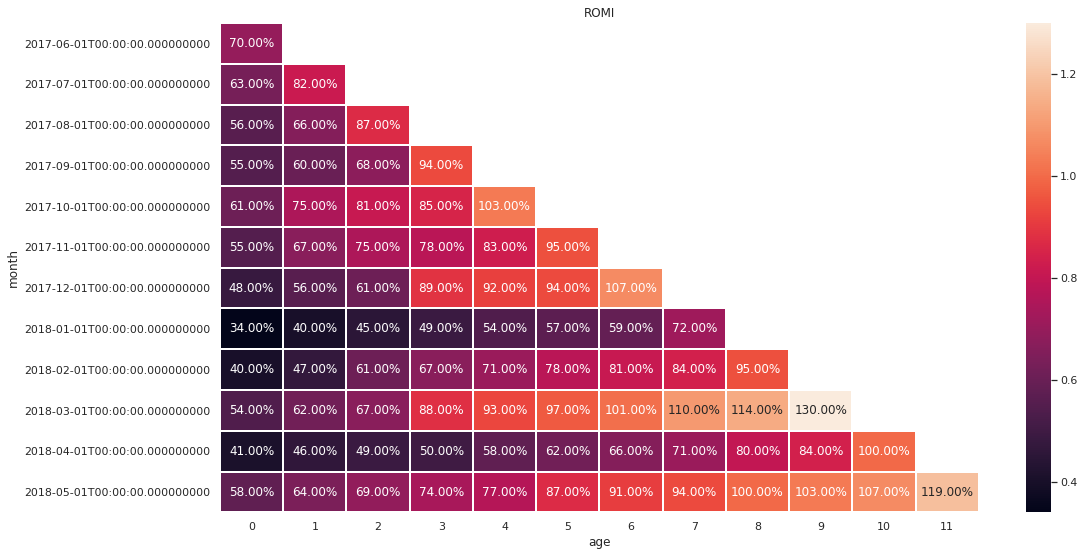

In [102]:
plt.figure(figsize=(17, 9))
plt.title('ROMI')
sns.heatmap(output_cohort_v2, annot=True, fmt='.2%', linewidths=1, linecolor='white')
plt.show()

In [103]:
output_cohort = df_final.pivot_table(
        index=['source_id','month'], 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)

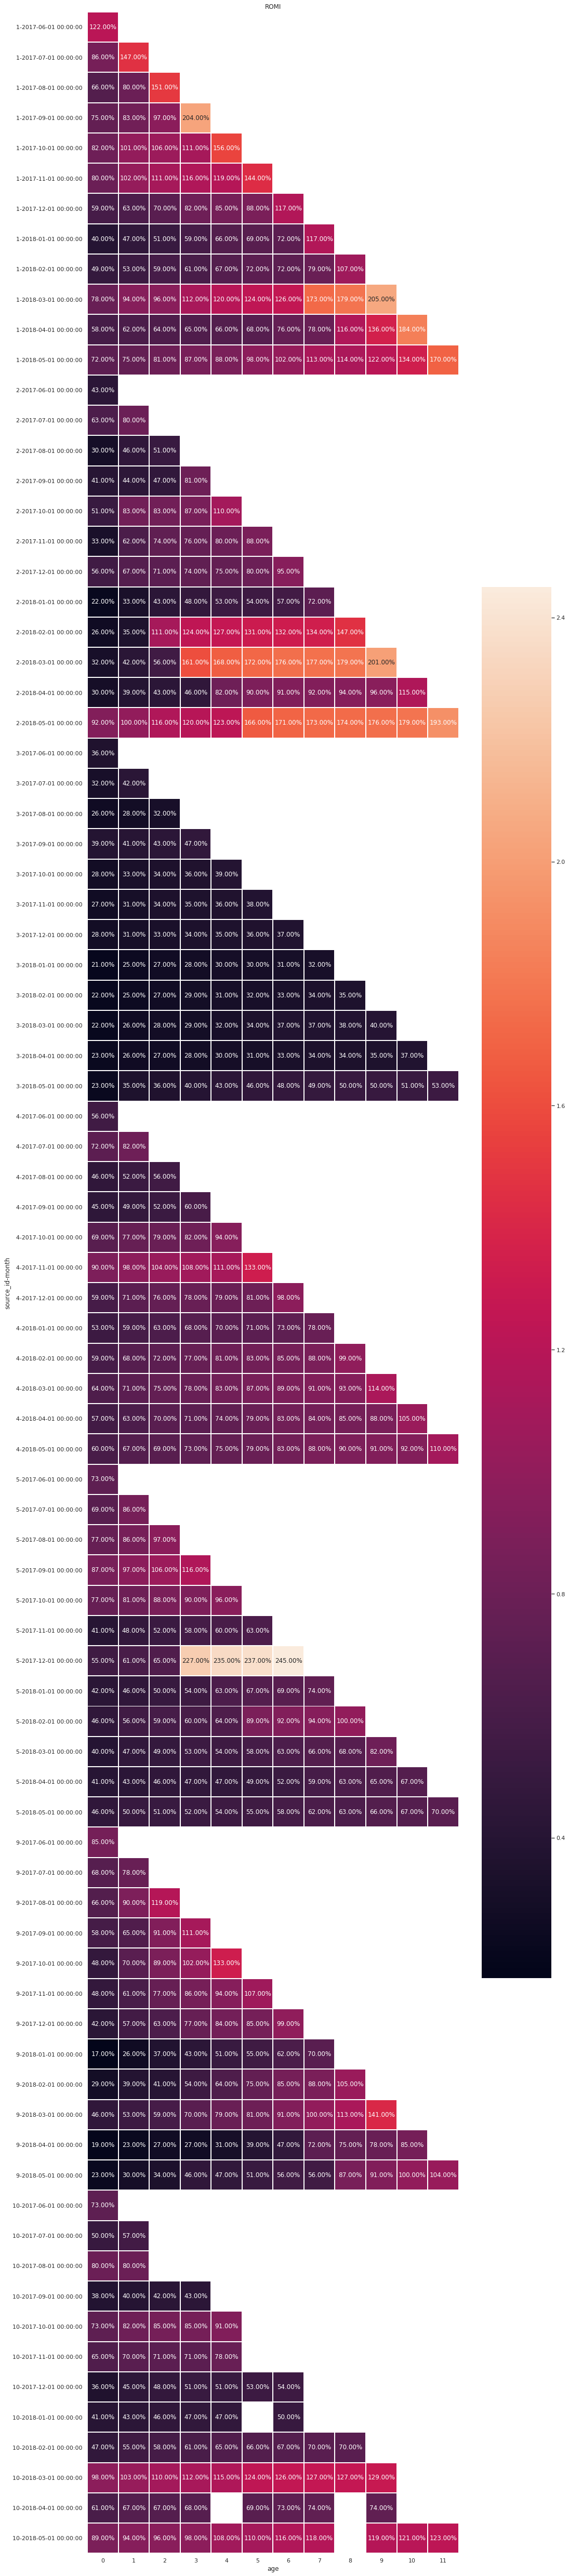

In [104]:
plt.figure(figsize=(16, 90))
plt.title('ROMI')
sns.heatmap(output_cohort, annot=True, fmt='.2%', linewidths=1, linecolor='white')
plt.show()

In [105]:
output = df_final.pivot_table(
        index='source_id', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)

In [106]:
output

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.72,0.87,1.00,1.18,1.27,1.35,1.42,1.64,1.83,2.01,2.31,2.67
2,0.43,0.57,0.72,0.91,1.01,1.12,1.17,1.20,1.25,1.33,1.44,1.59
3,0.27,0.32,0.34,0.36,0.38,0.39,0.41,0.42,0.43,0.44,0.45,0.46
4,0.61,0.68,0.72,0.76,0.80,0.86,0.91,0.94,0.99,1.06,1.15,1.34
5,0.58,0.65,0.70,0.91,0.95,1.01,1.05,1.09,1.12,1.18,1.20,1.23
9,0.46,0.58,0.70,0.81,0.90,0.96,1.05,1.14,1.30,1.42,1.50,1.54
10,0.63,0.68,0.70,0.72,0.76,0.79,0.82,0.83,0.84,0.85,0.87,0.89


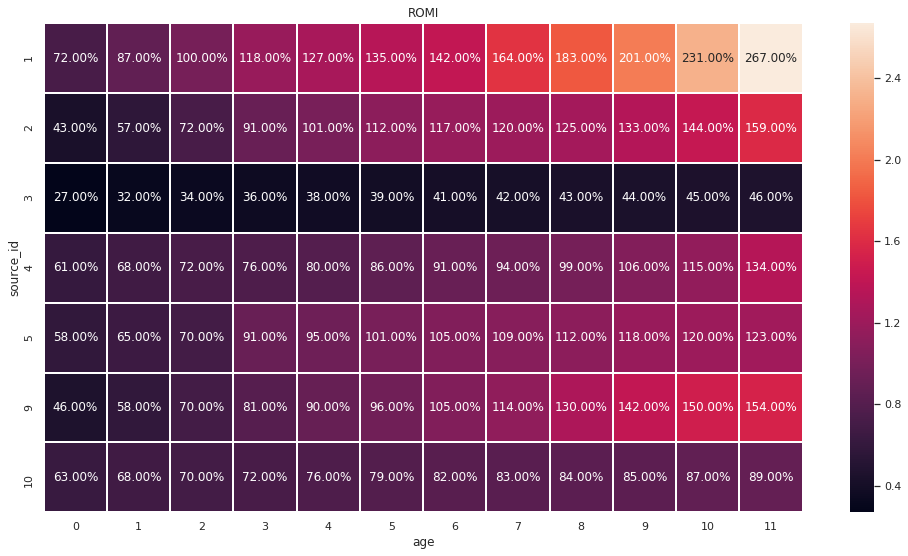

In [107]:
plt.figure(figsize=(17, 9))
plt.title('ROMI')
sns.heatmap(output, annot=True, fmt='.2%', linewidths=1, linecolor='white')
plt.show()

#### Выводы:
* Рекламные источники **3** и **10** не окупились даже за целый год.
* Самый окупаемый источник под номером **1**. Он и окупил себя быстрее всех - на 3 месяц, и по итогу в целом оказался самым прибыльным.
* По осталным источникам закономрность в сроке окупаемости не наблюдается. Так например источник под номером **4** хоть и принес больше чем источник под номером **5** по итогу года, окупился он только на 10 месяц, в то вермя как **5** окупился уже на 6 месяце. Надо выяснить чем был вызван такой скачок в **4** источнике. Возможно это была повторная email рассылка.
* В целом, смотря по источникам, которые себя окупают, не считая **1**, окупаемость наступает в  5 - 7 месяце.

### Общие выводы можно сделать следующие:<a class="anchor" id="step3"></a>
* В целом бизнес одноразовый, потому что люди практически не возвращаются, а свою первую покупку соверащют практически всегда в первый же день посещения.
* Стоит обратить внимание на источник под номером **1**, так как он быстрее всего окупается, думаю, в него следует вкладывать больше средтв для привлечения клиентов.
* Так же стоит обратить внимание на источник под номером **3**. Он окупает себя хуже всего, точнее совсем не покупает себя, при том что в него вкладывается больше всего средств.
* Изходя из послених двух пунктов, а в особенности третьего, марктетологам следует порекомендовать больше внимания уделять исследованию таких метрик как CAC, ROI и ROMI, так как благодаря именно вычислению этих метрик мы узнали, какие источники окупаются , а какие нет.
* Следует обратить внимание на месяц Май. Он принес больше всего выручки в сравнении с остальными месяцами, при том что затраты на маркеинг в этот месяц были довольно средними. Думаю это связано с большим кол-вом майских выходных.